# Introduction to $\texttt{flarestack}$
### Links ###
* Slides:  https://events.icecube.wisc.edu/event/140/contributions/7689/attachments/6114/7347/IceCube_tech_workshop_flarestack.pdf
* GitHub: https://github.com/icecube/flarestack
* More examples: https://mybinder.org/v2/gh/icecube/flarestack/master

### Logging ###
$\texttt{flarestack}$ uses logging. So to get an idea of what is going on, let's turn it on!  \
(We will use the INFO level. If you run into a problem and really want to know what's going on use DEBUG)

In [1]:
import logging
logging.basicConfig(level='INFO')

## 1. Installation ##
Execute
```bash
pip install --prefix=/path/to/lib flarestack
```
to install $\texttt{flarestack}$ into `/path/to/lib` space ***prior to executing this notebook***.
This will also install all necessary dependencies.  
For the purpose of this workshop: `path/to/lib=/scratch/<your_username>/`

### Set up external directories ###

To specify your **dataset directory** do
```bash
export FLARESTACK_DATASET_DIR=/path/to/datasets
```
If you are running at DESY or WIPAC this is not necesarry.  
The code products such as data, plots, caches, etc will be stored in a separate scratch directory.
To specify run
```bash
export FLARESTACK_SCRATCH_DIR=/path/to/scratch
```
If not given, defaults to home directory. For now we can use `/scratch/<your_username>/flarestack_scratch`

In [2]:
import os
os.environ['FLARESTACK_SCRATCH_DIR']

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch'

In [3]:
from flarestack.shared import host_server
from flarestack.data.icecube.ic_season import icecube_dataset_dir
print(f'Running at {host_server}, data directory is {icecube_dataset_dir}')

INFO:flarestack.shared:Scratch Directory is: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/input/pull_corrections/
INFO:flarestack.shared:Found Directory: /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/cluster/logs/
INFO:flarestack.shared:Fou

Running at None, data directory is /Users/thomasahrens/Desktop/IceCube/flarestack/datasets


In [4]:
from flarestack.shared import fs_scratch_dir
print(f'Scratch directory is {fs_scratch_dir}')

Scratch directory is /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/


## 2. Using Flarestack Classes

Classes used in $\texttt{flarestack}$'s core functionality (e.g. `flarestack.core.energy_pdf.EnergyPDF`, `flarestack.core.minimisation.MinimisationHandler`, etc) have a class attribute `<class>.subclasses`.  
This is a dictionary with the structure `{<subclass name>: <subclass>}`.  

In [5]:
from flarestack.core.minimisation import MinimisationHandler
MinimisationHandler.subclasses

{'fixed_weights': flarestack.core.minimisation.FixedWeightMinimisationHandler,
 'large_catalogue': flarestack.core.minimisation.LargeCatalogueMinimisationHandler,
 'fit_weights': flarestack.core.minimisation.FitWeightMinimisationHandler,
 'fit_weights_mcmc': flarestack.core.minimisation.FitWeightMCMCMinimisationHandler,
 'flare': flarestack.core.minimisation.FlareMinimisationHandler}

For analyses we only have to pass a dictionary of the subclass names and corresponding parameters.  
To execute use `flarestack.cluster.submitter.Submitter`. This always works locally. For using the cluster, again, if you are running at DESY or WIPAC, you do not have to worry. We got you covered.

In [6]:
from flarestack.cluster.submitter import Submitter
Submitter.submitter_dict

{'local': flarestack.cluster.submitter.LocalSubmitter,
 'DESY': flarestack.cluster.submitter.DESYSubmitter,
 'WIPAC': flarestack.cluster.submitter.WIPACSubmitter}

## 3. Example: Point Source Sensitivity ##

Let's try to calculate the 10-year point source sensitivity for one declination.  
First we have to specify a name for the analysis.

In [37]:
# Change gamma, minimizer, run number
name = "analyses/2source_gamma_2.0_mcmc_run4"

The input directory (with the analysis dictionaries), the output directory (plots, p-values, etc) and the cache directory (saved trials, etc) will be created accordingly.   
For example our plot output directory will be:

In [38]:
from flarestack.shared import plot_output_dir
plot_output_dir(name)

'/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_run4'

Many dataset implementations are available in `flarestack.data`. We will use the PS Tracks v3.2

In [39]:
# from flarestack.data.icecube import ps_v003_p02
from flarestack.data.public import icecube_ps_3_year

We want to inject a steady neutrino signal with a power law spectrum with $\gamma=2.5$. For other Energy or Time PDFs check `flarestack.core.energy_pdf` and `flarestack.core.time_pdf`.   \
This is as straight forward as:

In [40]:
injection_energy = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0
}

injection_time = {
    "time_pdf_name": "steady"
}

inj_kwargs = {
    "injection_energy_pdf": injection_energy,
    "injection_sig_time_pdf": injection_time
}

We are looking for a steady signal with a power law spectrum. 
We assume the background to be constant in time.  
We want to use the "standard" point source likelihood. More likelihood implementations in `flarestack.core.llh`

In [41]:
llh_time = {
    "time_pdf_name": "steady"
}

llh_energy = {
    "energy_pdf_name": "power_law",
}

llh_time_bkg = {
    "time_pdf_name": "steady"
}

llh_kwargs = {
    "llh_name": "standard",
    "llh_energy_pdf": llh_energy,
    "llh_sig_time_pdf": llh_time,
    "llh_bkg_time_pdf": llh_time_bkg
}

We need a source catalogue. This catalogue will be a numpy array stored as a `.npy` file and we only pass the filename.   
For point sources the is a uitility function to generate dummy sources.

In [42]:
# from flarestack.utils.prepare_catalogue import ps_catalogue_name
import numpy as np

sindec = 0.5
catalogue_path = "/Users/thomasahrens/Desktop/IceCube/sn-search/test_catalogue_2.npy"
print(f'your catalogue is located at {catalogue_path}')
catalog = np.load(catalogue_path)
catalog

your catalogue is located at /Users/thomasahrens/Desktop/IceCube/sn-search/test_catalogue_2.npy


array([(0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il'),
       (3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab')],
      dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')])

Now we make a guess for our sensitivity.   
Note: $\texttt{flarestack}$ is using its own scale factor $k$

In [43]:
from flarestack.shared import flux_to_k
flux_to_k(1)

999999999.9999999

Here we know where the sensitivity should be. Because the analysis has been done before.

In [44]:
logging.basicConfig(level='ERROR')
from flarestack.icecube_utils.reference_sensitivity import reference_sensitivity
scale = flux_to_k(reference_sensitivity(np.sin(catalog['dec_rad']))) * 3
scale

array([ 6.24859081, 24.92108471])

Now we just have to put all the info into one dictionary to pass to the `MinimisationHandler`

In [45]:
mh_dict = {
    "name": name,                                           # unique name for the analysis
    "mh_name": "fit_weights_mcmc",                          # name of the MinimisationHandler subcalss
    "dataset": icecube_ps_3_year.get_seasons("IC86-2012"),  # the neutrino dataset
    "catalogue": catalogue_path,                            # path to the .npy catalogue file
    "inj_dict": inj_kwargs,                                 # info for the Injector
    "llh_dict": llh_kwargs,                                 # info for the LLH
    "scale": np.max(scale),                                 # a guess for the sensitivity scale
    "n_trials": 10,                                         # number of trials to run (background trials will be run ten times this number!)
    "n_steps": 10,                                          # number of steps when injecting signal
    "allow_extrapolated_sensitivity": True                  # allow extrapolation in the sensitivity calculation (here we do because we only run very few trials)
}

To execute the analysis we defined above we create a submitter instance

In [46]:
submitter = Submitter.get_submitter(
    mh_dict=mh_dict,                         # the analysis info
    use_cluster=False,                       # run it on the cluster if True
    n_cpu=8,                                 # number of LOCAL CPUs to use, NOTE: the number of cluster CPUs has to be specified in the cluster_kwargs!
    do_sensitivity_scale_estimation=False,   # make a guess of the sensitivity scale, for options check flarestack.cluster.submitter
    remove_old_results=True,                 # if you are running the analysis again and something changed, maybe you want to remove old trials?
#   **cluster_kwargs                         # keyword arguments used when running the cluster, This depends on the cluster obviously
)

print(submitter)


----- Submitter for analyses/2source_gamma_2.0_mcmc_run4 -----
not using cluster 
using 8 CPUs locally
job-id: None 
no scale estimation 



Energise ......

In [47]:
submitter.analyse()

INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.injector:Initialising Injector for IC86-2012
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:Added 190 trials to queue. Now processing.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
INFO:flarestack.core.multiprocess_wrapper:190 tasks remaining.
INFO:flarestack.core.minimisation:Using 'standard' LLH class
/Users/thomasahrens/Desktop/IceCube/flarestack/flarestack/core/llh.py:912: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

To get the results we use the `ResultsHandler`. This will also create some plots like the sensitivity fit, bias plots, etc. in the plot directory.

In [48]:
from flarestack.core.results import ResultsHandler
results_handler = ResultsHandler(submitter.mh_dict)

INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_run4/bias_n_s (b'ASASSN-15ab').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_run4/bias_n_s (b'ASASSN-14il').pdf
INFO:flarestack.core.results:Saving bias plot to /Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/output/plots/analyses/2source_gamma_2.0_mcmc_run4/bias_gamma.pdf
INFO:flarestack.core.results:Fraction of overfluctuations is 0.50 above 3981.83 (N_trials=100) (Scale=0)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.40 above 3981.83 (N_trials=10) (Scale=2.769)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.30 above 3981.83 (N_trials=10) (Scale=5.538)
INFO:flarestack.core.results:Fraction of overfluctuations is 0.20 above 3981.83 (N_trials=1

In [49]:
print(fr'sensitivity flux: {results_handler.sensitivity:.2e} +{results_handler.sensitivity_err[1]}  -{results_handler.sensitivity_err[0]}')
print(f'reference: {reference_sensitivity(sindec)[0]}')
print(fr'sensitivity n_s: {results_handler.sensitivity * results_handler.flux_to_ns:.2e} +{results_handler.sensitivity_err[1] * results_handler.flux_to_ns}  -{results_handler.sensitivity_err[0] * results_handler.flux_to_ns}')

sensitivity flux: 4.24e-07 +-1.124615510686505e-06  -2.613638554556941e-07
reference: 5.770894709671131e-10
sensitivity n_s: 6.14e+01 +-162.91273431567691  -37.86138457007626


In [50]:
# help(results_handler)
# results_handler.results

In [51]:
rh_dict = results_handler.__dict__
rh_dict

{'sources': array([(3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab'),
        (0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il')],
       dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')]),
 'name': 'analyses/2source_gamma_2.0_mcmc_run4/',
 'mh_name': 'fit_weights_mcmc',
 'scale': 24.92108471278904,
 'results': {'19.38': {'TS': [3936.096709452483,
    3986.504363511965,
    3966.043903109911,
    3883.725886940187,
    3934.4672437660897,
    3981.0033038843644,
    3973.019946207857,
    3971.7217004800136,
    3974.836742008146,
    3989.4589602938963],
   'Parameters': {"n_s (b'ASASSN-15ab')": [999.4855175636534,
     999.3688617363733,
     999.5328779427741,
     999.4546237838716,
     999.4143608292741,
     999.4359246266366,
     999.47

### Write `results_handler` dict to pickle

In [22]:
import pickle

# Path to stored pickle data directory
rh_path = "/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma_2.0_mcmc_run3/"

# Write RH dict to pickle
with open(rh_path + 'RH', 'wb') as file:
    pickle.dump(rh_dict, file, pickle.HIGHEST_PROTOCOL)

In [23]:
# Open RH dict pickle
with open(rh_path + 'RH', 'rb') as file:
    loaded_rh_dict = pickle.load(file)

loaded_rh_dict

{'sources': array([(3.67889954, -0.67152028, 1., 1., nan, nan, nan, 1.64885347e+13, b'ASASSN-15ab'),
        (0.19872028, -0.24886844, 1., 1., nan, nan, nan, 2.04324986e+13, b'ASASSN-14il')],
       dtype=[('ra_rad', '<f8'), ('dec_rad', '<f8'), ('base_weight', '<f8'), ('injection_weight_modifier', '<f8'), ('ref_time_mjd', '<f8'), ('start_time_mjd', '<f8'), ('end_time_mjd', '<f8'), ('distance_mpc', '<f8'), ('source_name', 'S30')]),
 'name': 'analyses/2source_gamma_2.0_fit_run6/',
 'mh_name': 'fit_weights',
 'scale': 24.92108471278904,
 'results': {'19.38': {'TS': [10.089433498682514,
    29.72310674506816,
    7.095406359608715,
    23.815955985587337,
    5.359037961869137,
    9.281576579407437,
    11.839097360833346,
    0.0,
    17.49460828633153,
    12.807278027395174],
   'Parameters': {"n_s (b'ASASSN-15ab')": [1.6543977916049775,
     0.0,
     0.0,
     0.9786891644312421,
     1.0886670705504875,
     1.582270248741202,
     0.0,
     0.0,
     1.6733628175194155,
     1.4952

## 3.1. MCMC: Corner Plot

In [18]:
# Path to MCMC pickle directory
import pickle
mcmc_pickle_path = "/Users/thomasahrens/Desktop/IceCube/flarestack/scratch/flarestack__data/storage/pickles/analyses/2source_gamma_2.0_mcmc_run1/merged/"

# Open specific scale pickle (e.g., '0.pkl')
with open(mcmc_pickle_path + '11.11.pkl', 'rb') as file:
    mcmc_pickle = pickle.load(file)
    
mcmc_pickle

{'TS': [6.319287419687109,
  1.0593382303341832,
  5.878883398622362,
  3.8213336988963356,
  5.299728893872551,
  14.992019575301013,
  0.01203444552744043,
  8.275262995394183,
  0.06581110448157945,
  25.798586853629466],
 'Parameters': {"n_s (b'ASASSN-15ab')": [0.0,
   2.073918717137509,
   1.0641200639942938,
   0.0,
   1.0947851470726837,
   0.0,
   0.22238445595716752,
   0.0,
   0.0,
   0.0],
  "n_s (b'ASASSN-14il')": [1.0867719214237974,
   0.0,
   0.0,
   0.9521600574387106,
   1.4609403637600311,
   2.111642072881289,
   0.0,
   1.4603379528820126,
   0.25856728675006674,
   3.8199667086369886],
  'gamma': [1.0,
   4.0,
   1.1905655566051487,
   1.0,
   3.512476401652583,
   1.0037176794623461,
   3.425874200930367,
   1.734902619999732,
   2.95376050860578,
   1.3256517406576882]},
 'Flags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
# Get MCMC chains from dict
mcmc_chains = mcmc_pickle['chains']

# Number of dimensions
dim = 2

# Reshape MCMC chains
mcmc_chains = mcmc_chains.chain[4,...].reshape((-1,dim))

In [ ]:
from corner import corner

# Create corner plots showing burn in time for MCMC flarestack simulation chains
fig = corner(mcmc_chains,
#             labels=[r'$\tau$', r'$\kappa$', '$V_s$', r'$\epsilon$', r'$\omega$', r'$\chi$', '$b$'],
#             levels=[1-np.exp(-0.5*(x**2)) for x in range(1,4)],
#             range=[[1100,1350], [50,200], [-20,20], [0.4,0.9], [1.7*np.pi,2*np.pi], [0.12,0.32], [0.5,1.5]],
            plot_datapoints=False,
            bins=30)

## 4. Example: Upper Limits

There are some really useful functions in `flarestack.cosmo`!  

Take the implementations of the IceCube diffuse flux measurements for example:

In [24]:
from flarestack.cosmo.icecube_diffuse_flux import contours, get_diffuse_flux_contour
contours.keys()

dict_keys(['joint_15', 'northern_tracks_16', 'northern_tracks_17', 'northern_tracks_19'])

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'northern_tracks_16' from https://arxiv.org/abs/1607.08006
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'northern_tracks_17' from https://doi.org/10.22323/1.301.1005
INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'northern_tracks_19' from https://arxiv.org/abs/1908.09551


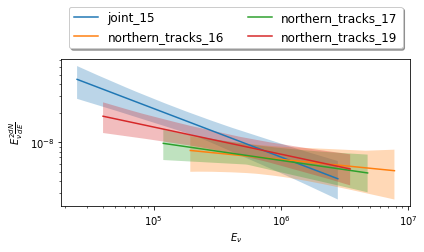

In [25]:
import matplotlib.pyplot as plt

plt.figure()
ax = plt.subplot(111)

for fit in contours.keys():

    best_fit, upper_butterfly, lower_butterfly, e_range = get_diffuse_flux_contour(fit)
    plt.plot(e_range, best_fit(e_range) * e_range**2, label=fit)
    plt.fill_between(e_range, upper_butterfly(e_range)* e_range**2, lower_butterfly(e_range)* e_range**2, alpha=0.3)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$E_{\nu}$")
plt.ylabel(r"$E_{\nu}^{2} \frac{dN}{dE}$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, fancybox=True, shadow=True, fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

If you are interested in transients you also are at the right place!  
With your favourte transients population's rate, the flux normaisation at 1 GeV and the corresponding spectral index you can easily get the rate in a redshift shell, the neutrino flux per source at a certain redshift, the neutrino flux per redshift and the cumulatice neutrino flux.

INFO:flarestack.cosmo.rates:Loading source class 'frb'
INFO:root:No evolution specified. Assuming default evolution.
INFO:root:Loaded evolution 'madau_14' (http://arxiv.org/abs/1403.0007v3)
INFO:root:No rate specified. Assuming default rate.
INFO:root:Loaded rate 'bochenek_20' (https://arxiv.org/abs/2005.10828)


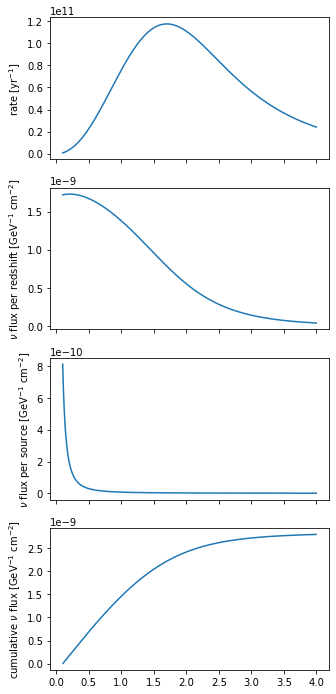

In [26]:
from flarestack.cosmo.neutrino_cosmology import define_cosmology_functions
from flarestack.cosmo.rates import get_rate
from astropy import units as u

frb_rate = get_rate('FRB')
frb_dummy_flux = 2e+46 / u.GeV
frb_example_gamma = 2

rate_per_z, nu_flux_per_z, nu_flux_per_source, cumulative_nu_flux = define_cosmology_functions(frb_rate, frb_dummy_flux, frb_example_gamma)

redshift = np.linspace(0.1, 4, 1000)

fig, axs = plt.subplots(4, sharex='all', figsize=[5, 12])
axs[0].plot(redshift, rate_per_z(redshift).to('yr-1').value)
axs[0].set_ylabel('rate [yr$^{-1}$]')

axs[1].plot(redshift, nu_flux_per_z(redshift).to('GeV-1 cm-2 s-1 sr-1').value)
axs[1].set_ylabel(r'$\nu$ flux per redshift [GeV$^{-1}$ cm$^{-2}$]')

axs[2].plot(redshift, nu_flux_per_source(redshift).to('GeV-1 cm-2').value)
axs[2].set_ylabel(r'$\nu$ flux per source [GeV$^{-1}$ cm$^{-2}$]')

axs[3].plot(redshift[1:-1], [i.to('1 / (cm2 GeV s sr)').value for i in cumulative_nu_flux(redshift)])
axs[3].set_ylabel(r'cumulative $\nu$ flux [GeV$^{-1}$ cm$^{-2}$]')
plt.show()
plt.close()

NOTE: The result of `cumulative_nu_flux()` is already your result for the contribution of the popultion to the diffuse flux!  

All the above is packed into one convenience function:

In [27]:
from flarestack.cosmo.neutrino_cosmology import calculate_transient_cosmology

Let's use this to get some actual super interesting, timely results and revisit the FRB  asscociated with the galactic Magnetar SGR 1935+2154 (https://arxiv.org/abs/2005.10828).  
IceCube performed a search for neutrinos and found upper limits:
```
IceCube Limit is E^2 dN/dE = 5.2 × 10−2 GeV cm^-2 @ 1 GeV 
```
(http://www.astronomerstelegram.org/?read=13689)  \
The Magnetar is 16 kpc away (conservative). Let's assume a spectrum with $\gamma=2$

In [28]:
from flarestack.core.energy_pdf import EnergyPDF

dist = 16 * u.kpc
atel_flux_norm_lim = 5.2 * 10**-2. * (u. GeV / u.cm**2) / u.GeV**2.

e_pdf_dict = {
    "energy_pdf_name": "power_law",
    "gamma": 2.0,
    "e_min_gev": 10.**3,
    "e_max_gev": 10.**6,
    "nu_flux_at_1_gev": atel_flux_norm_lim * 4 * np.pi * dist**2.
}

epdf = EnergyPDF.create(e_pdf_dict)

INFO:flarestack.core.energy_pdf:Minimum Energy is 1e+03 GeV.
INFO:flarestack.core.energy_pdf:Maximum Energy is 1e+06 GeV.


With these information it is now super straight forward to get the upper limits from a population of FRB's, that share SGR 1935+2154's properties, assuming they are all standard candels:

In [29]:
fit = "joint_15"
integrated_nu_flux_1_gev = calculate_transient_cosmology(e_pdf_dict, frb_rate, "frb_limit", zmax=8.0, diffuse_fit=fit)

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991
INFO:flarestack.cosmo.neutrino_cosmology:Using the joint_15 best fit values of the diffuse flux.
INFO:flarestack.cosmo.neutrino_cosmology:Diffuse Flux at 1 GeV: 7.0624201077093805e-06 1 / (cm2 GeV s sr)
INFO:flarestack.cosmo.neutrino_cosmology:Diffuse Spectral Index is 2.5
INFO:flarestack.cosmo.neutrino_cosmology:Neutrino Flux at 1 GeV is 1.6e+45 1 / GeV
INFO:flarestack.cosmo.neutrino_cosmology:Local rate is 0.072 1 / (Mpc3 yr)
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative sources at z=8.0: 2.9e+11
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative flux at z=8.0 (1 GeV): 2.4e-10 1 / (cm2 GeV s sr)
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative annual flux at z=8.0 (1 GeV): 0.0075 1 / (cm2 GeV sr)
INFO:flarestack.cosmo.neutrino_cosmology:Fraction of diffuse flux at 1GeV: 3.4e-05
INFO:flarestack.cosmo.neutrino_cosmology:Cumulative neutrino flux 2.4e-10 1 / (cm2 GeV s sr)

Let's plot our very interesting findings so we can publish in a prestegious journal!

INFO:flarestack.cosmo.icecube_diffuse_flux:Loaded contour 'joint_15' from https://arxiv.org/abs/1507.03991


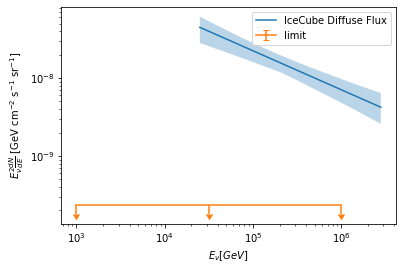

In [30]:
best_fit, upper_butterfly, lower_butterfly, e_range = get_diffuse_flux_contour(fit=fit)


plt.figure()
plt.plot(e_range, best_fit(e_range) * e_range**2, label="IceCube Diffuse Flux")
plt.fill_between(e_range, upper_butterfly(e_range)* e_range**2, lower_butterfly(e_range)* e_range**2, alpha=0.3)
x = [epdf.e_min, np.exp(0.5*(np.log(epdf.e_min) + np.log(epdf.e_max))), epdf.e_max]
y = np.array([integrated_nu_flux_1_gev.value for _ in range(3)]) 
plt.errorbar(x, y, yerr=0.25*y, uplims=True, label='limit')
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$E_{\nu} [GeV] $")
plt.ylabel(r"$E_{\nu}^{2} \frac{dN}{dE}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.legend()
plt.show()
plt.close()